Runs Greedy optimization of objective using GB1 dataset.

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 25})
plt.rcParams.update({'xtick.labelsize': 25})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt, bases

In [2]:
with open('../inputs/GB1.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
A = t[2]
y = t[3].values

In [7]:
wt = "VDGV"  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [4]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [28]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = [wt] + singles
train_inds = [seq_to_x[seq] for seq in train_seqs]
np.random.seed(120120)
train_inds = list(np.random.choice(len(X), 100, replace=True)) # generate random indices for 100 X's to sample from

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

A_train = A[train_inds]
A_test = A

In [6]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [7]:
def seqs_from_set(chosen, L):
    pos = [[c[0] for c in chosen if c[1] == p] for p in range(L)]
    return [''.join(s) for s in itertools.product(*pos)]

In [34]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100

observed_inds = [train_inds]
X_sampled = [A[train_inds]]
y_sampled = [y[train_inds]]



libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test, one_hots=X_test, its=2000, lr=1e-2)
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    print()
    seed = helpers.get_seed(dic)
    chosen, obj = bases.greedy(dic, seed, n, L)
    libraries.append(chosen)
    histories.append(obj)
    seqs = seqs_from_set(chosen, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(A[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    
    

Round 0
100
Iteration 2000 of 2000	NLML: 48.4962	sn: 0.199951	
Round 1
200
Iteration 2000 of 2000	NLML: 93.3991	sn: 0.180702	
Round 2
264
Iteration 2000 of 2000	NLML: 65.5891	sn: 0.043452	
Round 3
328
Iteration 2000 of 2000	NLML: 19.2149	sn: 0.013059	


In [35]:
libraries

[[('W', 0),
  ('N', 1),
  ('Q', 2),
  ('W', 3),
  ('A', 0),
  ('R', 1),
  ('R', 2),
  ('A', 3),
  ('R', 0),
  ('D', 1),
  ('D', 2),
  ('C', 3),
  ('N', 0),
  ('C', 1),
  ('Q', 3),
  ('F', 2),
  ('C', 0),
  ('E', 3),
  ('G', 2),
  ('M', 1),
  ('E', 0),
  ('L', 3),
  ('I', 0),
  ('G', 3),
  ('L', 0),
  ('H', 3),
  ('P', 0),
  ('V', 1),
  ('P', 3),
  ('F', 0),
  ('I', 3),
  ('K', 0),
  ('V', 2),
  ('G', 0),
  ('F', 3),
  ('D', 0),
  ('G', 1),
  ('Y', 3),
  ('V', 0),
  ('S', 3),
  ('R', 3)],
 [('G', 0),
  ('C', 1),
  ('Q', 2),
  ('I', 3),
  ('V', 1),
  ('M', 3),
  ('F', 3),
  ('I', 1),
  ('R', 0),
  ('Y', 1),
  ('V', 3),
  ('L', 3),
  ('K', 0),
  ('W', 1),
  ('A', 3),
  ('H', 0)],
 [('A', 0),
  ('Y', 1),
  ('Q', 2),
  ('L', 3),
  ('C', 1),
  ('I', 3),
  ('S', 0),
  ('R', 2),
  ('V', 1),
  ('G', 0),
  ('T', 1),
  ('A', 3),
  ('H', 1),
  ('R', 1),
  ('S', 1)],
 [('G', 0),
  ('H', 1),
  ('R', 2),
  ('A', 3),
  ('A', 0),
  ('S', 1),
  ('G', 3),
  ('R', 1),
  ('V', 0),
  ('W', 1),
  ('I', 0),
 

In [36]:
histories

[tensor(-0.1515), tensor(-1.6765), tensor(-4.4212), tensor(-8.9474)]

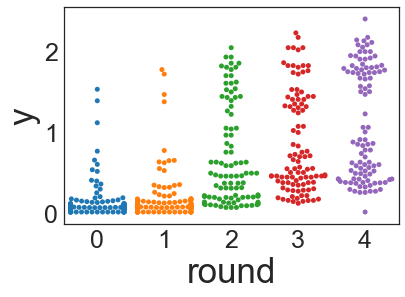

In [39]:
df = pd.DataFrame(np.exp(np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (100) + [1] * n + [2] * n + [3] * n + [4] * n
_ = sns.swarmplot(data=df, x='round', y='y')

In [40]:
[max(yy) for yy in y_sampled]

[0.42967125497365644,
 0.5768266000449709,
 0.7184390982375426,
 0.8039462204271667,
 0.8782151067154043]

In [41]:
[opt.get_N(lib, L) for lib in libraries]

[8232, 120, 126, 120]

In [42]:
df.to_csv('../outputs/greedy_gb1.txt', index=False)